In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table as pd_table
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score

In [2]:
#Data Load
dataf = pd.read_csv("../Datasets/MVPdata_final.csv")

In [3]:
df = dataf[((dataf['G']>48)&(dataf['PTS']>13.5)&(dataf['MP']>30)
           &(dataf['AST']>1)&(dataf['TRB']>3)&(dataf['FG%']>0.37))]
df['Odds'] = -df['Odds']
df = df.iloc[:, 2:]

C:\Users\xx049\AppData\Local\Temp\ipykernel_2152\3983626552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Odds'] = -df['Odds']


In [4]:
#Set Test Season
test_season = 2023
train_df = df[df['Season'] < test_season]
dftest = df[df['Season'] == test_season]

In [5]:
df.columns

Index(['Season', 'Rank', 'Player', 'Pos', 'Age', 'G', 'MP', 'PTS', 'AST',
       'TRB', 'STL', 'BLK', 'FG%', 'eFG%', 'FT%', 'PF', 'WS', 'WS/48', 'First',
       'Pts Won', 'Pts Max', 'Share', 'MVP', 'Raptor Offense',
       'Raptor Defense', 'Predator Offense', 'Predator Defense', 'Odds'],
      dtype='object')

In [6]:
#Feature Selections
features =  ['TRB','AST', 'MP','STL', 'G', 'PTS', 'WS', 'FG%', 'Raptor Offense','Raptor Defense','Predator Offense','Predator Defense', 'Odds']
X = df[features]

In [7]:
#Setting share as the target
y = df['Share']

In [8]:
#Dataset Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Bayesian Model

In [9]:
#Bayesian Training
bayesian_model = BayesianRidge()

In [10]:
bayesian_model.fit(X_train, y_train)

BayesianRidge()

In [11]:
#Run predictions
y_pred_bayesian = bayesian_model.predict(X_test)

Bayesian Ridge Model Accuracy (R-Squared)): 59.19%


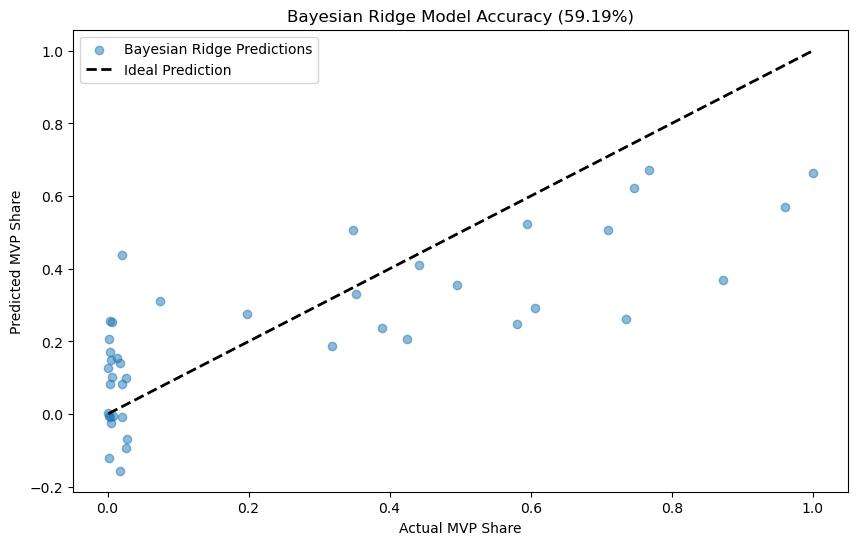

In [12]:
#Evaluation
r2_bayesian = r2_score(y_test, y_pred_bayesian)
print(f"Bayesian Ridge Model Accuracy (R-Squared)): {r2_bayesian * 100:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_bayesian, alpha=0.5, label='Bayesian Ridge Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual MVP Share')
plt.ylabel('Predicted MVP Share')
plt.title('Bayesian Ridge Model Accuracy (59.19%)')
plt.legend()
plt.savefig('images/br_accuracy.png')
plt.show()

In [13]:
#Calculate correlations
correlation_matrix = df[features + ['Share']].corr()
#Select correlations of features with the target variable
target_correlations = correlation_matrix['Share'].drop('Share')
target_correlations_df = target_correlations.to_frame(name='Correlation Coefficient')

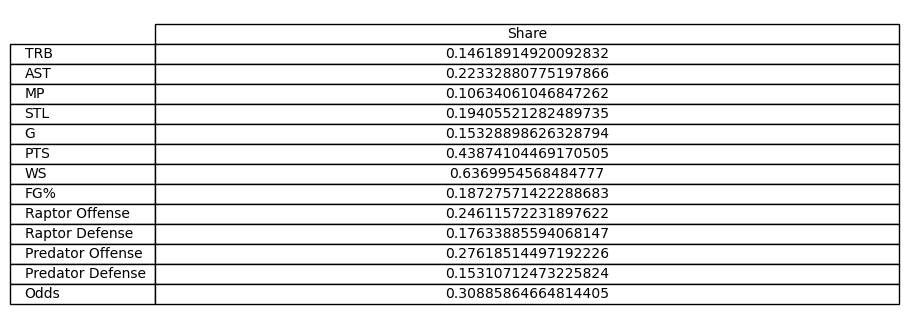

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')

#Create the table
correlation_table = pd_table(ax, target_correlations, loc='center', cellLoc='center')
correlation_table.auto_set_font_size(False)
correlation_table.set_fontsize(10)
correlation_table.scale(1.2, 1.2)

plt.savefig('images/target_correlations.png', bbox_inches='tight', dpi=300)
plt.show()

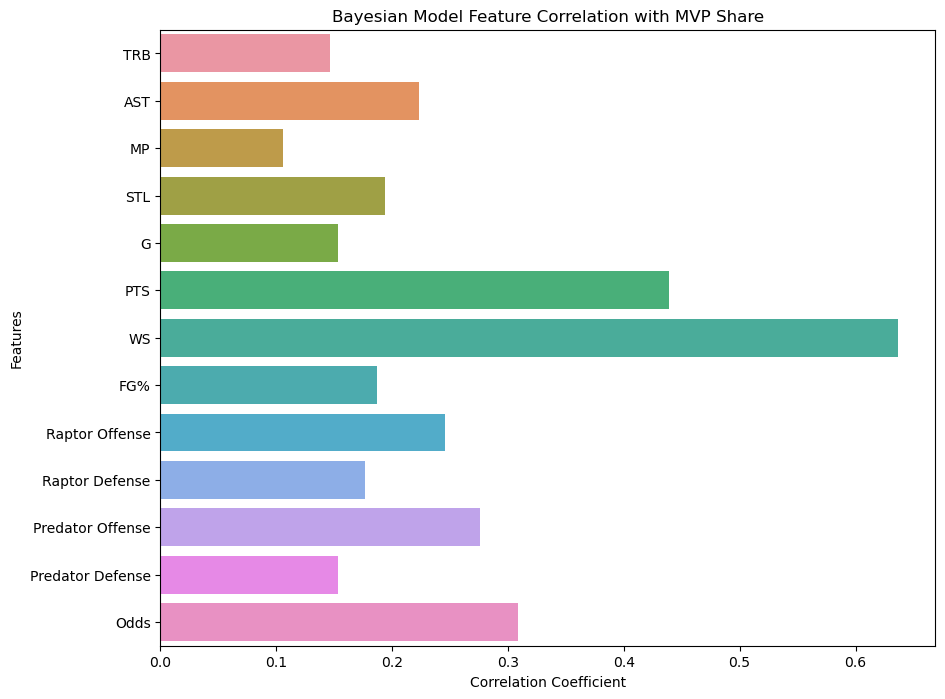

In [15]:
# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=target_correlations.values, y=target_correlations.index)
plt.title('Bayesian Model Feature Correlation with MVP Share')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.savefig('images/feature_correlation.png')
plt.show()

In [16]:
X_test = dftest[features]
#Run predictions
y_pred_test = bayesian_model.predict(X_test)

#Making Dataframe
predicted_shares = pd.DataFrame({
    'Player': dftest['Player'],
    'Predicted Share': y_pred_test,
    'Actual Share': dftest['Share'],
    'Actual Placement': dftest['Rank']
})
predicted_shares = predicted_shares.sort_values(by='Predicted Share', ascending=False)

In [17]:
comparison_df = pd.merge(predicted_shares, dftest[['Player', 'Share']], on='Player', how='inner')
comparison_df.drop(columns=['Share'], inplace=True)
top_three_comparison = comparison_df.sort_values(by='Predicted Share', ascending=False).head(3)
top_three_comparison.set_index('Player', inplace=True)
top_three_comparison['Predicted Share'] = top_three_comparison['Predicted Share'].apply(lambda x: f"{x:.3f}")
# Display the top three rows
top_three_comparison

,Predicted Share,Actual Share,Actual Placement
Player,,,
Nikola Jokic,0.561,0.674,2
Joel Embiid,0.510,0.915,1
Luka Doncic,0.372,0.010,8


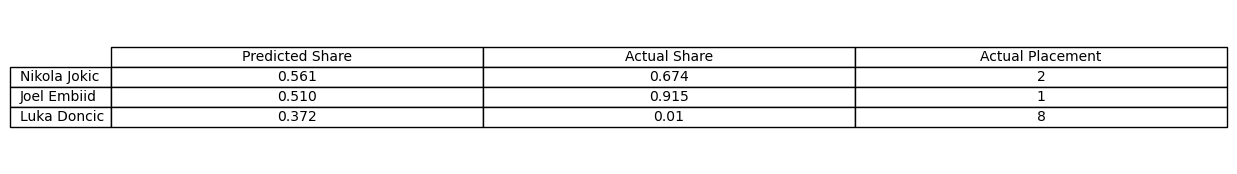

In [18]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')
ax.axis('off')

pd_table = pd_table(ax, top_three_comparison, loc='center', cellLoc='center')
pd_table.auto_set_font_size(False)
pd_table.set_fontsize(10)
pd_table.scale(1.2, 1.2) 

filename = f'images/top_three_comparison_{test_season}.png'

#Save
plt.savefig(filename, bbox_inches='tight', dpi=300)